In [1]:
import numpy as np
import nibabel as nib

from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

### Plot for first gradients first

In [25]:
dmri_fname  = 'HumanBF-Parcellation/results/Grad_corr/Diff_resampled_gradient_{0}.nii.gz'
rfmri_fname = 'HumanBF-Parcellation/results/Func_HCPMMP/Func_HCPMMP_gradient_{0}.nii.gz'

dmri_g1_nii = nib.load(dmri_fname.format(0))
rfmri_g1_nii  = nib.load(rfmri_fname.format(0))

dmri_g1  = dmri_g1_nii.get_fdata()
rfmri_g1 = rfmri_g1_nii.get_fdata()

dmri_mask = np.where(dmri_g1, 1, 0)
rfmri_mask = np.where(rfmri_g1, 1, 0)

combined_mask = np.zeros_like(dmri_mask)
combined_mask[(dmri_mask==1) & (rfmri_mask==1)] = 1

In [26]:
# Get X, Y, Z coordinates
ijk_indices = np.argwhere(combined_mask)
ijk_indices = np.hstack((ijk_indices,np.ones((len(ijk_indices),1))))

affine = rfmri_g1_nii.affine

xyz_coords = np.dot(ijk_indices, affine)

In [27]:
# Here we flip along the X axis to give left and right same color codes
new_ijk_indices = ijk_indices.copy()
new_ijk_indices[:,0] = np.abs((combined_mask.shape[0]/2)-ijk_indices[:,0])

In [28]:
# Create RGB array
min_max_scaler = preprocessing.MinMaxScaler()

c = np.zeros((len(new_ijk_indices),3))
c[:,0] = min_max_scaler.fit_transform(new_ijk_indices[:,0][:,np.newaxis])[:,0]
c[:,1] = min_max_scaler.fit_transform(new_ijk_indices[:,1][:,np.newaxis])[:,0]
c[:,2] = min_max_scaler.fit_transform(new_ijk_indices[:,2][:,np.newaxis])[:,0]

In [29]:
# Rescale gradient values between 0 and 1
dmri_rescaled = min_max_scaler.fit_transform(dmri_g1[combined_mask==1][:,np.newaxis])
rfmri_rescaled = min_max_scaler.fit_transform(rfmri_g1[combined_mask==1][:,np.newaxis])

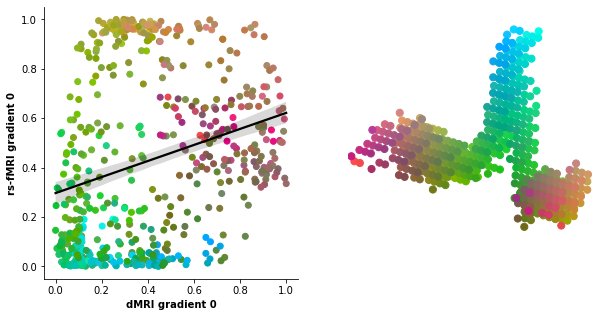

In [30]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)

ax1.scatter(dmri_rescaled, rfmri_rescaled, c=c)
# ax1.axhline(y=0, color='black', linestyle='--')
# ax1.axvline(x=0, color='black', linestyle='--')

ax1.set_xlabel('dMRI gradient 0', weight='bold')
ax1.set_ylabel('rs-fMRI gradient 0', weight='bold')

# Add fit line
sns.regplot(
    x=dmri_rescaled,
    y=rfmri_rescaled,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)

sns.despine()

# Add 3D scatterplot for visualizing RGB values
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.dist=6
ax2.set_axis_off()

ax2.scatter(
    ijk_indices[:,0],
    ijk_indices[:,1],
    ijk_indices[:,2],
    s=50, alpha=1,
    c=c
)

plt.show()

### Repeat for all gradients 

In [8]:
from scipy.stats import linregress

In [16]:
r_matrix = np.zeros((5,5))

for g in range(0,5):
    dmri_g = nib.load(dmri_fname.format(g)).get_fdata()
    dmri_g_rescaled = min_max_scaler.fit_transform(dmri_g[combined_mask==1][:,np.newaxis])

    for gg in range(0,5):
        rfmri_g = nib.load(rfmri_fname.format(gg)).get_fdata()
        rfmri_g_rescaled = min_max_scaler.fit_transform(rfmri_g[combined_mask==1][:,np.newaxis])

        res = linregress(dmri_g[combined_mask==1].flatten(), rfmri_g[combined_mask==1].flatten())
        r_matrix[g,gg] = res.rvalue**2

In [1]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.heatmap(r_matrix, cmap='bwr', center=0, linewidth=1, linecolor='black', square=True,
           cbar_kws={'label':'R-squared'})

ax.set_ylabel('dMRI gradient', weight='bold')
ax.set_xlabel('rs-fMRI gradient', weight='bold')

plt.show()

NameError: name 'plt' is not defined